In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime as dt


In [2]:
df = pd.read_csv('Online Retail Data.csv', header = 0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5.0,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1.0,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5.0,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1.0,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1.0,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1.0,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4.0,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1.0,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1.0,2010-12-23 17:41:00,1.25,NaN


In [3]:
df.shape

(461773, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  451726 non-null  object 
 2   product_name  449008 non-null  object 
 3   quantity      451726 non-null  float64
 4   order_date    451726 non-null  object 
 5   price         451726 non-null  float64
 6   customer_id   353282 non-null  float64
dtypes: float64(3), object(4)
memory usage: 24.7+ MB


# Data Cleansing

In [7]:
import pandas as pd
import numpy as np
from scipy import stats

# Copy the original dataframe
df_clean = df.copy()

# Convert 'order_date' to datetime
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])

# Create 'year_month' column
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

# Remove rows with missing 'customer_id' and 'product_name'
df_clean = df_clean.dropna(subset=['customer_id', 'product_name'])

# Convert 'product_name' to lowercase
df_clean['product_name'] = df_clean['product_name'].str.lower()

# Filter out rows where 'product_code' or 'product_name' contain 'test'
df_clean = df_clean[~df_clean['product_code'].str.lower().str.contains('test') &
                    ~df_clean['product_name'].str.contains('test ')]

# Create 'order_status' column
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1] == 'C', 'Cancelled', 'Delivered')

# Ensure 'quantity' is positive
df_clean['quantity'] = df_clean['quantity'].abs()

# Remove rows with non-positive 'price'
df_clean = df_clean[df_clean['price'] > 0]

# Calculate 'amount'
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

# Find the most frequent 'product_name' for each 'product_code'
most_freq_product_name = (
    df_clean.groupby(['product_code', 'product_name'], as_index=False)
    .agg(order_cnt=('order_id', 'nunique'))
    .sort_values(['product_code', 'order_cnt'], ascending=[True, False])
)

# Rank the product names by order count and keep the most frequent one
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank'] == 1].drop(columns=['order_cnt', 'rank'])

# Merge the most frequent product names back to the main dataframe
df_clean = df_clean.merge(
    most_freq_product_name.rename(columns={'product_name': 'most_freq_product_name'}),
    how='left',
    on='product_code'
)

# Update 'product_name' with the most frequent product name
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

# Ensure 'customer_id' is of type string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

# Remove outliers using Z-score for 'quantity' and 'amount'
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity', 'amount']])) < 3).all(axis=1)]

# Reset the index
df_clean = df_clean.reset_index(drop=True)

df_clean


<ipython-input-7-9c9d2c4fb840>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['product_name'] = df_clean['product_name'].str.lower()
<ipython-input-7-9c9d2c4fb840>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['amount'] = df_clean['quantity'] * df_clean['price']


,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1.0,2010-01-04 09:43:00,4.25,14590.0,2010-01,Cancelled,4.25
1,493414,21844,red retrospot mug,36.0,2010-01-04 10:28:00,2.55,14590.0,2010-01,Delivered,91.80
2,493414,21533,retro spot large milk jug,12.0,2010-01-04 10:28:00,4.25,14590.0,2010-01,Delivered,51.00
3,493414,37508,new england ceramic cake server,2.0,2010-01-04 10:28:00,2.55,14590.0,2010-01,Delivered,5.10
4,493414,35001G,hand open shape gold,2.0,2010-01-04 10:28:00,4.25,14590.0,2010-01,Delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
350960,539988,84380,set of 3 butterfly cookie cutters,1.0,2010-12-23 16:06:00,1.25,18116.0,2010-12,Delivered,1.25
350961,539988,84849D,hot baths soap holder,1.0,2010-12-23 16:06:00,1.69,18116.0,2010-12,Delivered,1.69
350962,539988,84849B,fairy soap soap holder,1.0,2010-12-23 16:06:00,1.69,18116.0,2010-12,Delivered,1.69
350963,539988,22854,cream sweetheart egg holder,2.0,2010-12-23 16:06:00,4.95,18116.0,2010-12,Delivered,9.90


In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350965 entries, 0 to 350964
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      350965 non-null  object        
 1   product_code  350965 non-null  object        
 2   product_name  350965 non-null  object        
 3   quantity      350965 non-null  float64       
 4   order_date    350965 non-null  datetime64[ns]
 5   price         350965 non-null  float64       
 6   customer_id   350965 non-null  object        
 7   year_month    350965 non-null  datetime64[ns]
 8   order_status  350965 non-null  object        
 9   amount        350965 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(5)
memory usage: 26.8+ MB


# EKSPLORASI DATA ANALYSIS

In [19]:
df_clean.describe()

,quantity,order_date,price,amount
count,350965.000000,350965,350965.000000,350965.000000
mean,9.338800,2010-07-23 00:17:17.398145280,3.111666,16.859841
min,1.000000,2010-01-04 09:43:00,0.001000,0.001000
25%,2.000000,2010-04-25 15:50:00,1.250000,4.250000
50%,4.000000,2010-08-03 14:23:00,1.950000,10.200000
75%,12.000000,2010-10-25 13:14:00,3.750000,17.700000
max,216.000000,2010-12-23 16:06:00,311.990000,315.000000
std,16.334223,NaN,5.544583,25.474206


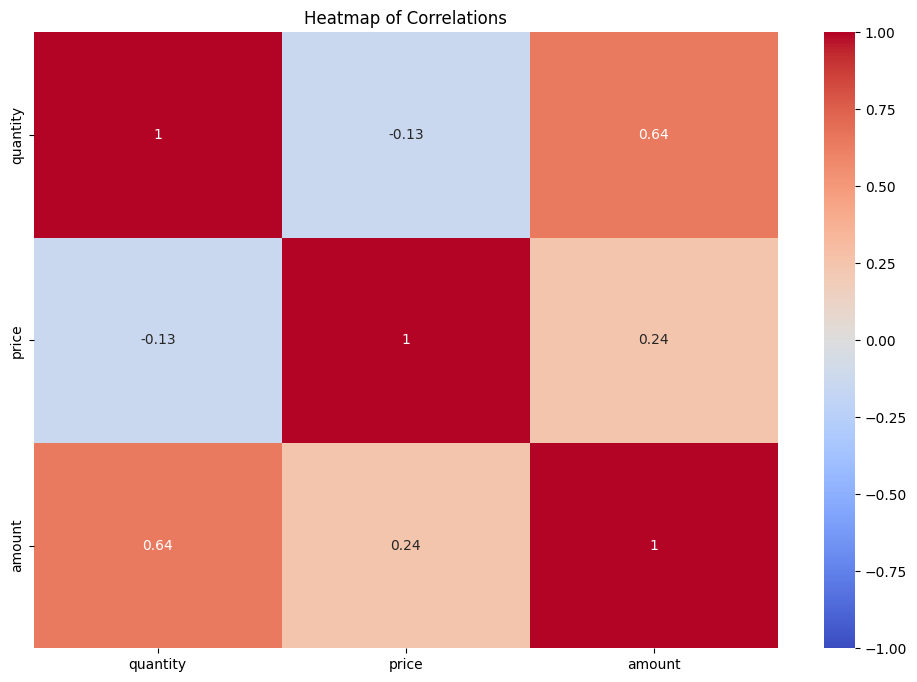

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop 'customer_id' column and keep only numeric columns
df_corr = df_clean.drop(columns=['customer_id'])

# Filter to keep only numeric columns
df_corr = df_corr.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlations')
plt.show()


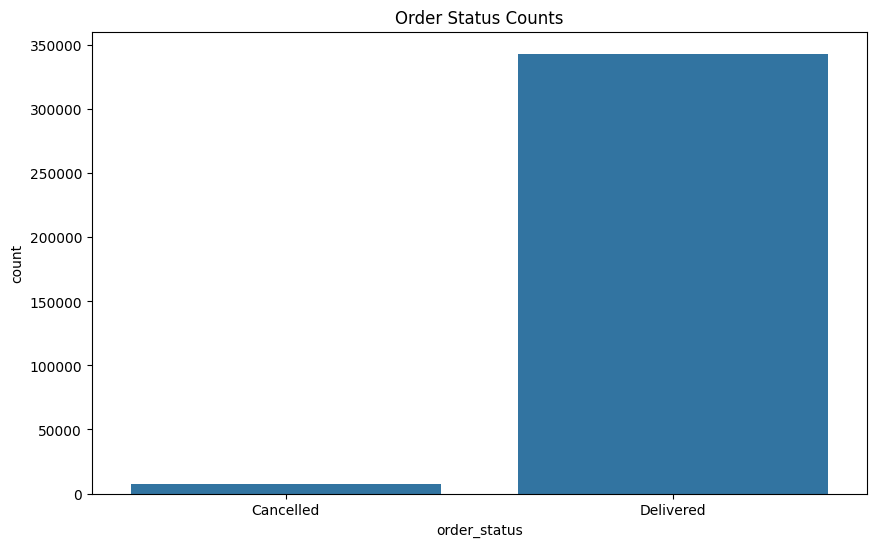

In [29]:

df_analys = df_clean.copy()

# Bar Plot of Order Status Counts
plt.figure(figsize=(10, 6))
sns.countplot(x='order_status', data=df_analys)
plt.title('Order Status Counts')
plt.show()


# membuat user retention cohort

## Agregat data transaksi ke bentuk summary total transaksi/order setiap pengguna setiap bulan

In [10]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'], as_index=False).agg(order_cnt=('order_id','nunique'))
df_user_monthly


,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
12027,18286.0,2010-06,1
12028,18286.0,2010-08,1
12029,18287.0,2010-05,1
12030,18287.0,2010-09,2


## Buat kolom sebagai cohort dari pengguna, misal cohort bulan pertama kali bertransaksi

In [11]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12027,18286.0,2010-06,1,2010-06
12028,18286.0,2010-08,1,2010-06
12029,18287.0,2010-05,1,2010-05
12030,18287.0,2010-09,2,2010-05


## Hitung jarak bulan antara bulan transaksi dengan bulan pertama kali transaksi dan jumlahkan dengan 1 agar jarak bulan 0 menjadi 1 yang berarti bulan pertama, dst.

In [12]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12027,18286.0,2010-06,1,2010-06,1
12028,18286.0,2010-08,1,2010-06,3
12029,18287.0,2010-05,1,2010-05,1
12030,18287.0,2010-09,2,2010-05,5


## Tabel pivot dengan index berupa cohort, kolom berupa jarak bulan, dan nilainya adalah banyaknya pengguna unik (count unique dari ID pengguna)

In [13]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index ="cohort", columns = 'period_num', values = 'customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,335.0,249.0
2010-02,460.0,154.0,128.0,161.0,152.0,120.0,119.0,159.0,153.0,166.0,100.0,NaN
2010-03,527.0,145.0,158.0,145.0,139.0,123.0,149.0,186.0,193.0,96.0,NaN,NaN
2010-04,325.0,81.0,75.0,63.0,69.0,79.0,98.0,101.0,50.0,NaN,NaN,NaN
2010-05,274.0,54.0,50.0,52.0,52.0,72.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,266.0,52.0,56.0,60.0,65.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,180.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,47.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,60.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hitung banyaknya pengguna di masing-masing cohort (pengguna yang pertama kali transaksi di bulan tersebut) dan bagi semua nilai di tabel pivot tadi dengan nilai tersebut sebagai retention rate

In [14]:
cohort_size = df_cohort_pivot.iloc[:,0]
cohort_size

cohort
2010-01    713.0
2010-02    460.0
2010-03    527.0
2010-04    325.0
2010-05    274.0
2010-06    266.0
2010-07    180.0
2010-08    160.0
2010-09    227.0
2010-10    361.0
2010-11    327.0
2010-12     65.0
Freq: M, Name: 1, dtype: float64

In [15]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis = 0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334783,0.278261,0.350000,0.330435,0.260870,0.258696,0.345652,0.332609,0.360870,0.217391,NaN
2010-03,1.0,0.275142,0.299810,0.275142,0.263757,0.233397,0.282732,0.352941,0.366224,0.182163,NaN,NaN
2010-04,1.0,0.249231,0.230769,0.193846,0.212308,0.243077,0.301538,0.310769,0.153846,NaN,NaN,NaN
2010-05,1.0,0.197080,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,NaN,NaN,NaN,NaN
2010-06,1.0,0.195489,0.210526,0.225564,0.244361,0.319549,0.146617,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.211111,0.205556,0.288889,0.294444,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.293750,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.264317,0.136564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Tampilkan tabel pivot yang sudah berisi nilai retention rate tersebut dalam heatmap

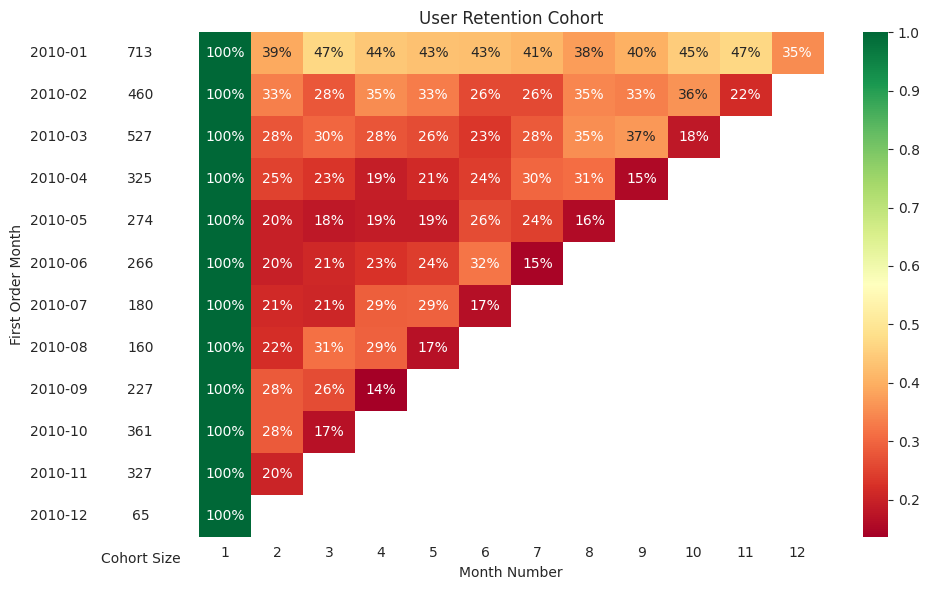

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('white'):
  fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, gridspec_kw={'width_ratios':[1, 9]})


  # user retention cohort
  sns.heatmap(df_retention_cohort, annot =True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
  ax[1].set_title('User Retention Cohort')
  ax[1].set(xlabel='Month Number', ylabel='')

  df_cohort_size = pd.DataFrame(cohort_size)
  white_cmap = mcolors.ListedColormap(['white'])
  sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
  ax[0].tick_params(bottom=False)
  ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

fig.tight_layout()





# Analisa Data

1. Pengguna paling banyak pertama kali bertransaksi pada Januari 2010 (713 pengguna).

2. Cohort pengguna tersebut juga yang paling banyak bertransaksi kembali di bulan ke-2 mereka (39% retention rate) dibanding cohort yang lain.

3. Selain itu, cohort tersebut jugalah yang paling loyal bertransaksi selama bulan-bulan berikutnya dengan retention rate ~40%+.

4. Sayangnya, sebagian besar pengguna tidak kembali bertransaksi, terlihat dari retention rate di banyak cohort dan bulan yang nilainya tak sampai 50%.

5. Yang cukup mengkhawatirkan, retention rate di Desember 2010 menjadi yang terendah untuk semua cohort pengguna dibanding bulan-bulan sebelumnya.

# THANK YOU